In [ ]:
! pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor
from loader_util.preprocessing import AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from imutils import paths
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [ ]:
# script constants
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/flowers17/images"
model_save_dir = r""
batch_size = 32
num_epochs = 25

In [ ]:
# construct the imagegenerator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [ ]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(dataset_path))
all_class_names = [pth.split(os.path.sep)[-2] for pth in image_paths]
class_names = np.unique(all_class_names)
class_names

[INFO] loading images......


array(['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus',
       'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris',
       'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily',
       'tulip', 'windflower'], dtype='<U10')

In [ ]:
# init the image processors
aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths=image_paths, verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [ ]:
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                test_size=0.25,
                                                random_state=42)

# encode the labels
lb = LabelBinarizer()
trainy_encoded = lb.fit_transform(trainy)
testy_encoded = lb.transform(testy)

In [ ]:
# initilise the base model
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_tensor=Input(shape=(224, 224, 3)))

head_model = FCHeadNet.build(base_model=base_model,
                             output_classes=len(class_names),
                             dense_layer_nodes=[256])
model = Model(inputs=base_model.input, outputs=head_model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# now train the model
print(f"[INFO] compiling the model......")
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling the model......


In [ ]:
# training the head for a few epochs
print(f"[INFO] training the head......")
H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=batch_size),
              validation_data=(testx, testy_encoded),
              epochs=num_epochs,
              steps_per_epoch=len(trainx) // batch_size,
              verbose=1)

[INFO] training the head......


<ipython-input-12-3b719cea8406>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=batch_size),


Epoch 1/25
31/31 [==============================] - 34s 642ms/step - loss: 4.8128 - accuracy: 0.1518 - val_loss: 2.0750 - val_accuracy: 0.4265
Epoch 2/25
31/31 [==============================] - 14s 452ms/step - loss: 2.2873 - accuracy: 0.2834 - val_loss: 1.6819 - val_accuracy: 0.5176
Epoch 3/25
31/31 [==============================] - 14s 462ms/step - loss: 2.0761 - accuracy: 0.3644 - val_loss: 1.4107 - val_accuracy: 0.5676
Epoch 4/25
31/31 [==============================] - 14s 465ms/step - loss: 1.8046 - accuracy: 0.4130 - val_loss: 1.2434 - val_accuracy: 0.6176
Epoch 5/25
31/31 [==============================] - 13s 429ms/step - loss: 1.7057 - accuracy: 0.4383 - val_loss: 1.2559 - val_accuracy: 0.5441
Epoch 6/25
31/31 [==============================] - 14s 467ms/step - loss: 1.5065 - accuracy: 0.5081 - val_loss: 0.9364 - val_accuracy: 0.7471
Epoch 7/25
31/31 [==============================] - 14s 449ms/step - loss: 1.4728 - accuracy: 0.5253 - val_loss: 0.9093 - val_accuracy: 0.7441

[INFO] evaluating network...
11/11 [==============================] - 2s 139ms/step
              precision    recall  f1-score   support

    bluebell       0.70      0.95      0.81        20
   buttercup       1.00      0.85      0.92        20
   coltsfoot       0.88      0.88      0.88        16
     cowslip       0.56      0.95      0.71        19
      crocus       0.87      0.87      0.87        15
    daffodil       0.93      0.70      0.80        20
       daisy       1.00      0.83      0.90        23
   dandelion       0.92      0.85      0.88        27
  fritillary       0.89      0.89      0.89        19
        iris       1.00      0.86      0.92        21
  lilyvalley       0.79      0.83      0.81        18
       pansy       1.00      0.88      0.93        16
    snowdrop       0.83      0.91      0.87        22
   sunflower       1.00      1.00      1.00        23
   tigerlily       0.94      0.94      0.94        18
       tulip       0.81      0.65      0.72        

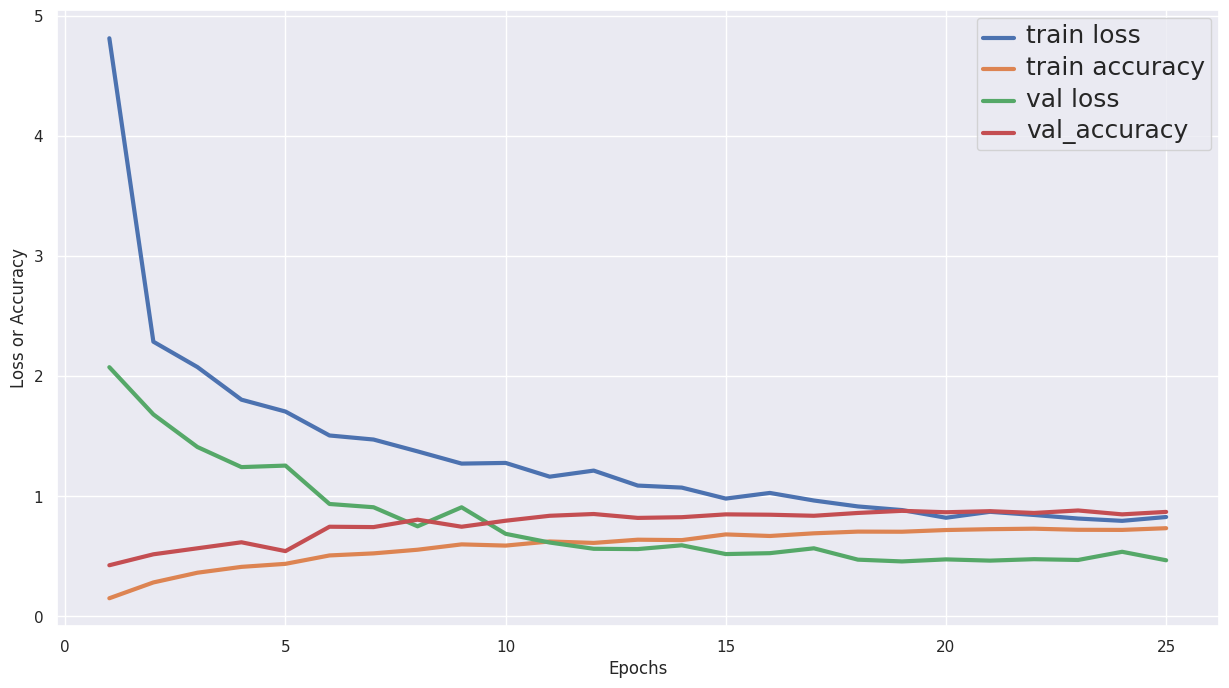

In [ ]:
# evaluate the model
print("[INFO] evaluating network...")
predictions = model.predict(testx, batch_size=batch_size)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

# plot the performance
epochs = range(1, num_epochs + 1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');  # for legend text

In [ ]:
# now unfreeze the last few layers
for layer in base_model.layers[15:]:
    layer.trainable = True

In [ ]:
# now train the model
print(f"[INFO] re-compiling the model......")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling the model......


In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
# training the head for a few epochs
print(f"[INFO] fine tuning the model......")

H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=batch_size),
              validation_data=(testx, testy_encoded),
              epochs=100,
              steps_per_epoch=len(trainx) // batch_size,
              verbose=1)

[INFO] fine tuning the model......


<ipython-input-17-31fcb8385a76>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainx, trainy_encoded, batch_size=batch_size),


Epoch 1/100
31/31 [==============================] - 19s 516ms/step - loss: 0.6360 - accuracy: 0.7925 - val_loss: 0.3330 - val_accuracy: 0.9000
Epoch 2/100
31/31 [==============================] - 14s 468ms/step - loss: 0.6248 - accuracy: 0.7854 - val_loss: 0.3295 - val_accuracy: 0.9000
Epoch 3/100
31/31 [==============================] - 15s 473ms/step - loss: 0.6142 - accuracy: 0.7935 - val_loss: 0.3267 - val_accuracy: 0.8971
Epoch 4/100
31/31 [==============================] - 16s 503ms/step - loss: 0.4754 - accuracy: 0.8451 - val_loss: 0.3217 - val_accuracy: 0.9147
Epoch 5/100
31/31 [==============================] - 15s 463ms/step - loss: 0.4731 - accuracy: 0.8391 - val_loss: 0.2857 - val_accuracy: 0.9029
Epoch 6/100
31/31 [==============================] - 13s 409ms/step - loss: 0.4993 - accuracy: 0.8310 - val_loss: 0.3246 - val_accuracy: 0.9118
Epoch 7/100
31/31 [==============================] - 13s 433ms/step - loss: 0.4763 - accuracy: 0.8431 - val_loss: 0.2920 - val_accuracy:

[INFO] evaluating network after finetuning...
11/11 [==============================] - 1s 125ms/step
              precision    recall  f1-score   support

    bluebell       0.95      0.95      0.95        20
   buttercup       0.95      1.00      0.98        20
   coltsfoot       0.94      1.00      0.97        16
     cowslip       0.85      0.89      0.87        19
      crocus       0.93      0.87      0.90        15
    daffodil       0.95      0.90      0.92        20
       daisy       1.00      0.87      0.93        23
   dandelion       1.00      0.93      0.96        27
  fritillary       1.00      1.00      1.00        19
        iris       0.95      1.00      0.98        21
  lilyvalley       1.00      0.94      0.97        18
       pansy       1.00      1.00      1.00        16
    snowdrop       0.95      0.95      0.95        22
   sunflower       1.00      1.00      1.00        23
   tigerlily       0.90      1.00      0.95        18
       tulip       0.90      0.90 

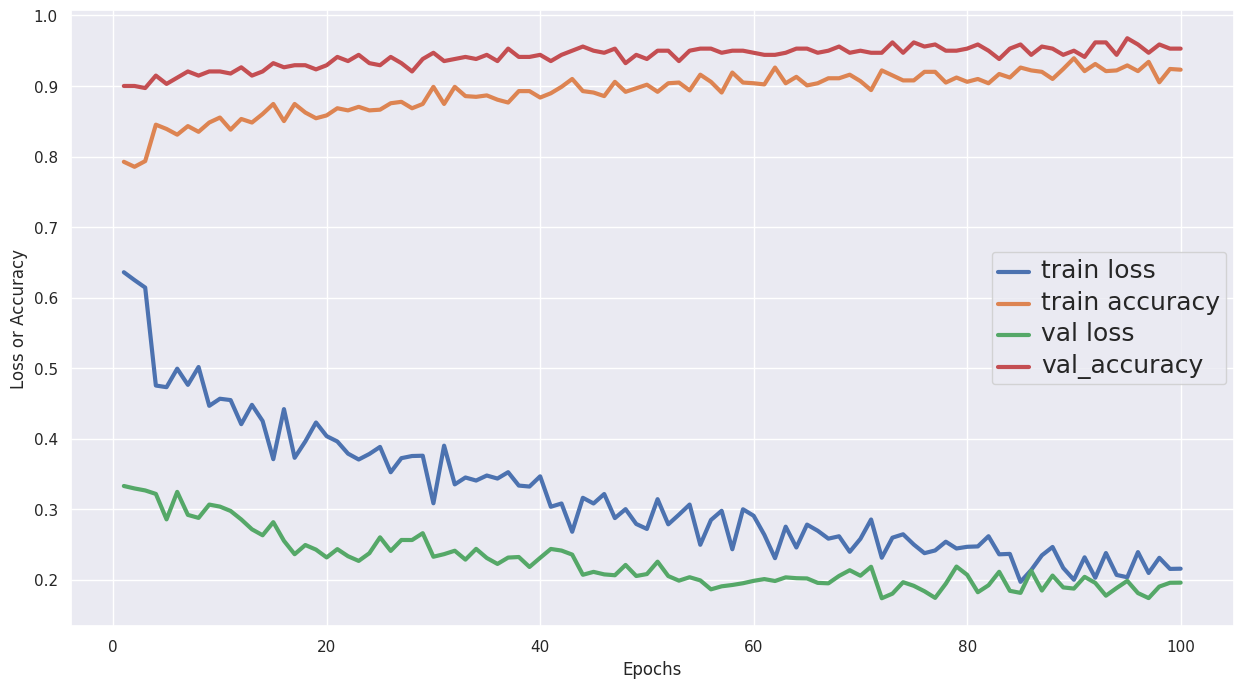

In [ ]:
# evaluate the model
print("[INFO] evaluating network after finetuning...")
predictions = model.predict(testx, batch_size=batch_size)
print(classification_report(testy_encoded.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=class_names))

# plot the performance
epochs = range(1, 100 + 1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');